# Predicting Invasive Ductual Carcinoma (IDC) in tissue slices.

## Motivation

Invase Ductual Carcinoma (IDC) is the most common types of breast cancer. It's malicious and able to form metastases which makes it especially dangerous. Often a biopsy is done to remove small tissue samples. Then a pathologist has to decide whether a patient has IDC, another type of breast cancer or is healthy. In addition sick cells need to be located to find out how advanced the disease is and which grade should be assigned. This has to be done manually and is a time consuming process. Furthermore the decision depends on the expertise of the pathologist and his or her equipment. Therefor deep learning could be of great help to automatically detect and locate tumor tissue cells and to speed up the process. In order to exploit the full potential one could build a pipeline using massive amounts of tissue image data of various hospitals that were evaluated by different experts. This way one would be able to overcome the dependence on the pathologist which would be especially useful in regions where no experts are available .

## Our goal

The goal is to create a deep learning model that can be used to ease the work of the pathologist so that they can check the tissue samples in greater batches and in a more efficient manner.

This requires the model to be highly accurate i.e. above 85% accuracy and have good recall in both negative and postive classes.


## What is meant by invasive ductal carcinoma? <a class="anchor" id="intro"></a>

<a title="Mikael Häggström, M.D. - Author info - Reusing images [CC BY (https://creativecommons.org/licenses/by/2.5)]" href="https://commons.wikimedia.org/wiki/File:Lobules_and_ducts_of_the_breast.jpg"><img width="309" alt="Lobules and ducts of the breast" style="float:left; margin:0px 15px 15px 15px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Lobules_and_ducts_of_the_breast.jpg/256px-Lobules_and_ducts_of_the_breast.jpg"></a>


This illustration created [Mikael Häggström](https://commons.wikimedia.org/wiki/File:Lobules_and_ducts_of_the_breast.jpg) shows the anatomy of a healthy breast. One can see the lobules, the glands that can produce milk which flews through the milk ducts. Ductal carcinoma starts to develop in the ducts whereas lobular carcinoma has its origin in the lobules. Invasive carcinoma is able to leave its initial tissue compartment and can form metastases. 

In [32]:
#importing necissary libraries

from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
from os import listdir
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.io import imread
import itertools
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [33]:
# Removing duplicate folders to save space before running the notebook

shutil.rmtree('/kaggle/working/all_images_dir', ignore_errors=True)
shutil.rmtree('/kaggle/working/base_dir', ignore_errors=True)

## Exploring the Data Structure

In [34]:
files = listdir("E:/FINAL_PROJECT/Breast_Cancer/Breast-cancer-detection-using-CNN/notebook/archive (13)")
print(len(files))

280


In [35]:
#looking at first 10 folders
files[0:10]

['10253',
 '10254',
 '10255',
 '10256',
 '10257',
 '10258',
 '10259',
 '10260',
 '10261',
 '10262']

#### In each folder there are several images and each folder name is the id of the patient

In [36]:

base_path = "E:/FINAL_PROJECT/Breast_Cancer/Breast-cancer-detection-using-CNN/notebook/archive (13)/IDC_regular_ps50_idx5/"
folders = os.listdir(base_path)  # List all patient folders
print("No. of Patients:", len(folders))

No. of Patients: 279


#### We have to find the number of total images in the dataset

In [37]:
total_images = 0

for patient_id in folders:
    patient_path = os.path.join(base_path, patient_id)  # Use os.path.join for safe concatenation
    for c in [0, 1]:  # Class 0 and 1
        class_path = os.path.join(patient_path, str(c))  # Construct class folder path
        if os.path.exists(class_path):  # Check if the path exists
            subfiles = os.listdir(class_path)  # List files in class folder
            total_images += len(subfiles)
        else:
            print(f"Class folder {class_path} not found.")  # Log missing folders

print("Total Images in dataset:", total_images)

Total Images in dataset: 277524


#### Organizing the data into pandas data frame

In [38]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

patient_id                                               path target
0      10253  E:/FINAL_PROJECT/Breast_Cancer/Breast-cancer-d...      0
1      10253  E:/FINAL_PROJECT/Breast_Cancer/Breast-cancer-d...      0
2      10253  E:/FINAL_PROJECT/Breast_Cancer/Breast-cancer-d...      0
3      10253  E:/FINAL_PROJECT/Breast_Cancer/Breast-cancer-d...      0
4      10253  E:/FINAL_PROJECT/Breast_Cancer/Breast-cancer-d...      0

#### Shape of data frame[](http://)

In [39]:
data.shape

(277524, 3)

## Exploring the data

C:\Users\DAI.STUDENTSDC\AppData\Local\Temp\ipykernel_14776\816341240.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.groupby('patient_id').size(), ax=ax[0], color='Orange', kde=False, bins=30)
C:\Users\DAI.STUDENTSDC\AppData\Local\Temp\ipykernel_14776\816341240.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372

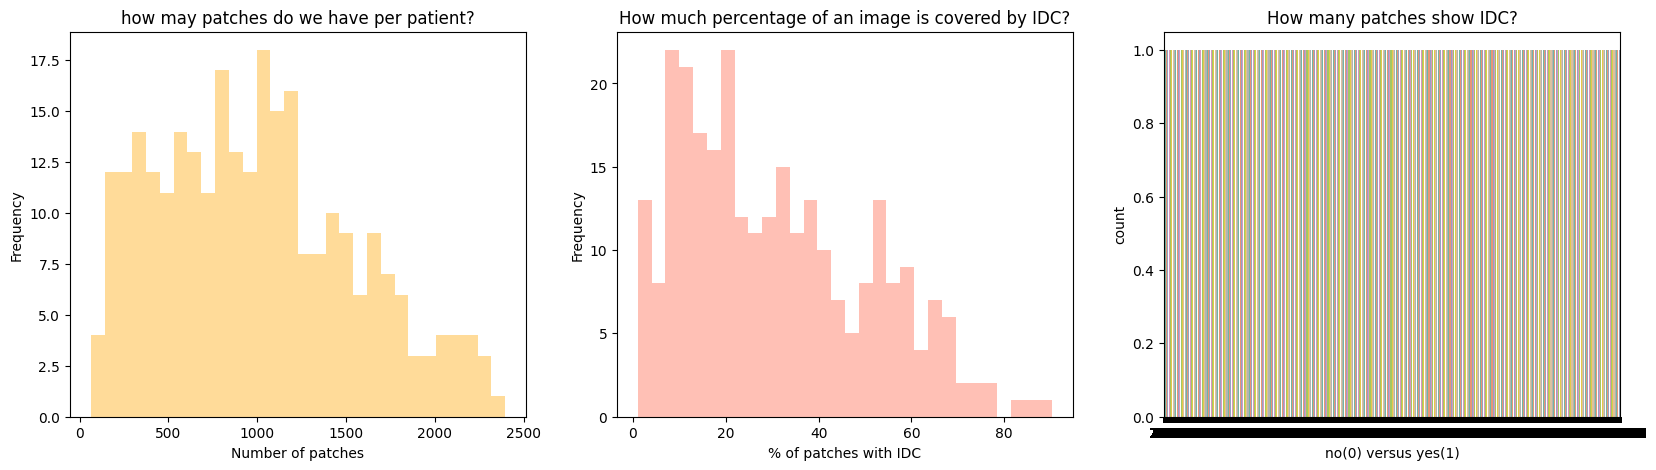

In [40]:
cancer_perc = data.groupby("patient_id").target.value_counts() / data.groupby("patient_id").target.size()
canxer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1, 3,figsize = (20,5))
sns.distplot(data.groupby('patient_id').size(), ax=ax[0], color='Orange', kde=False, bins=30)
ax[0].set_xlabel('Number of patches')
ax[0].set_ylabel('Frequency')
ax[0].set_title('how may patches do we have per patient?')
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");


### Insights

* The numbe rof image patches per patient varie's a lot.

* Some patients have more than 80 % patches that show IDC! Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer. 

* The classes of IDC versus no IDC are imbalanced.

In [41]:
# coverting target to int
data.target = data.target.astype(int)

### Displaying Cnacer Tissue Samples

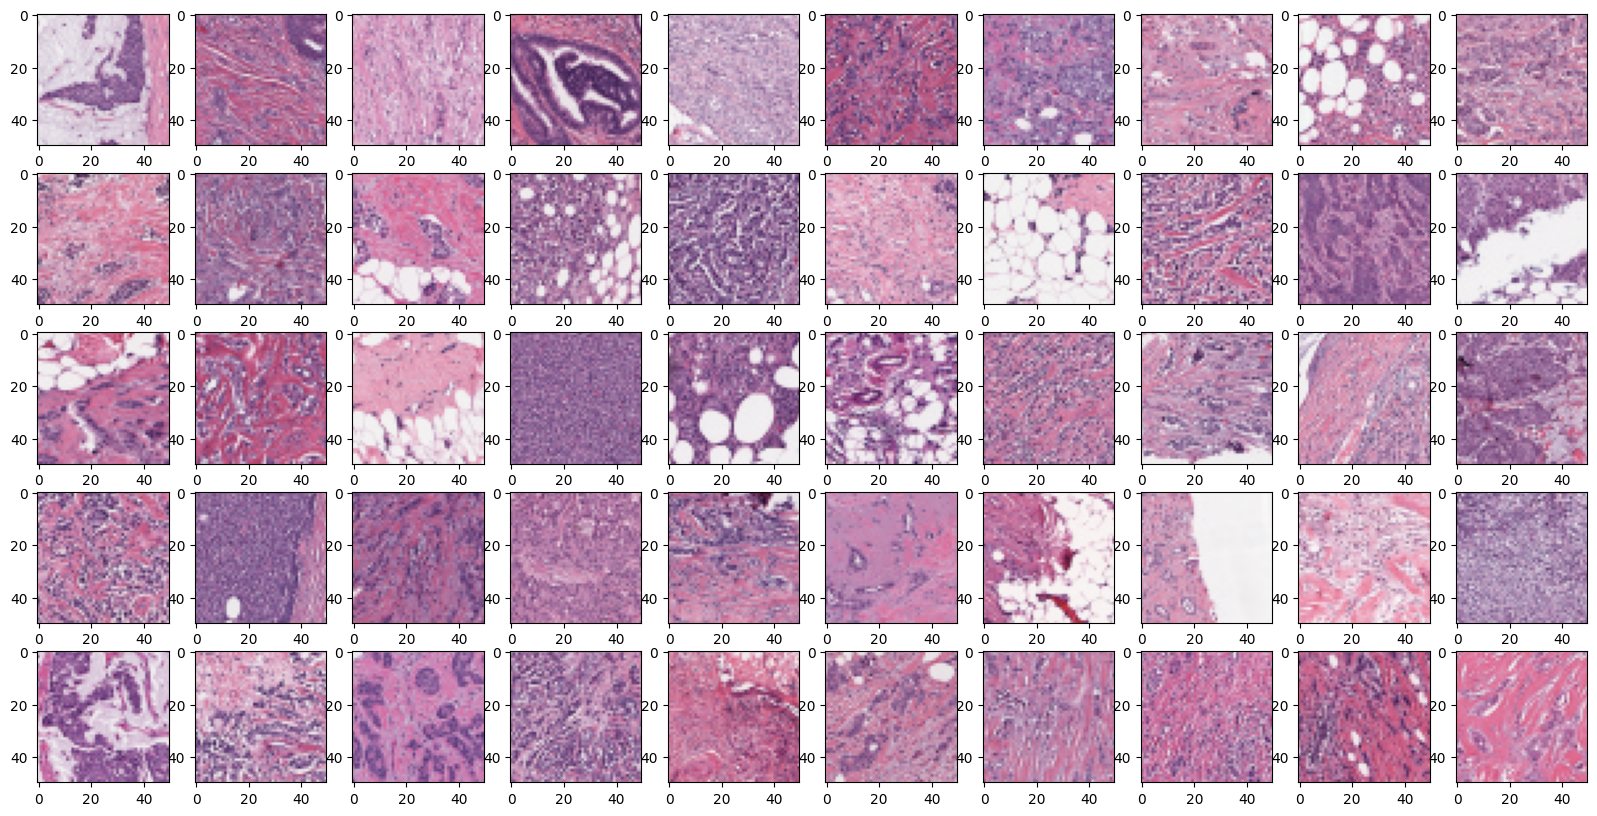

In [42]:
cancer_selection = np.random.choice(data[data.target == 1].index.values, size=50, replace=False)

fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for n in range(5):
    for m in range(10):
        idx = cancer_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)


### Displaying Non-Cnacer Tissue Samples

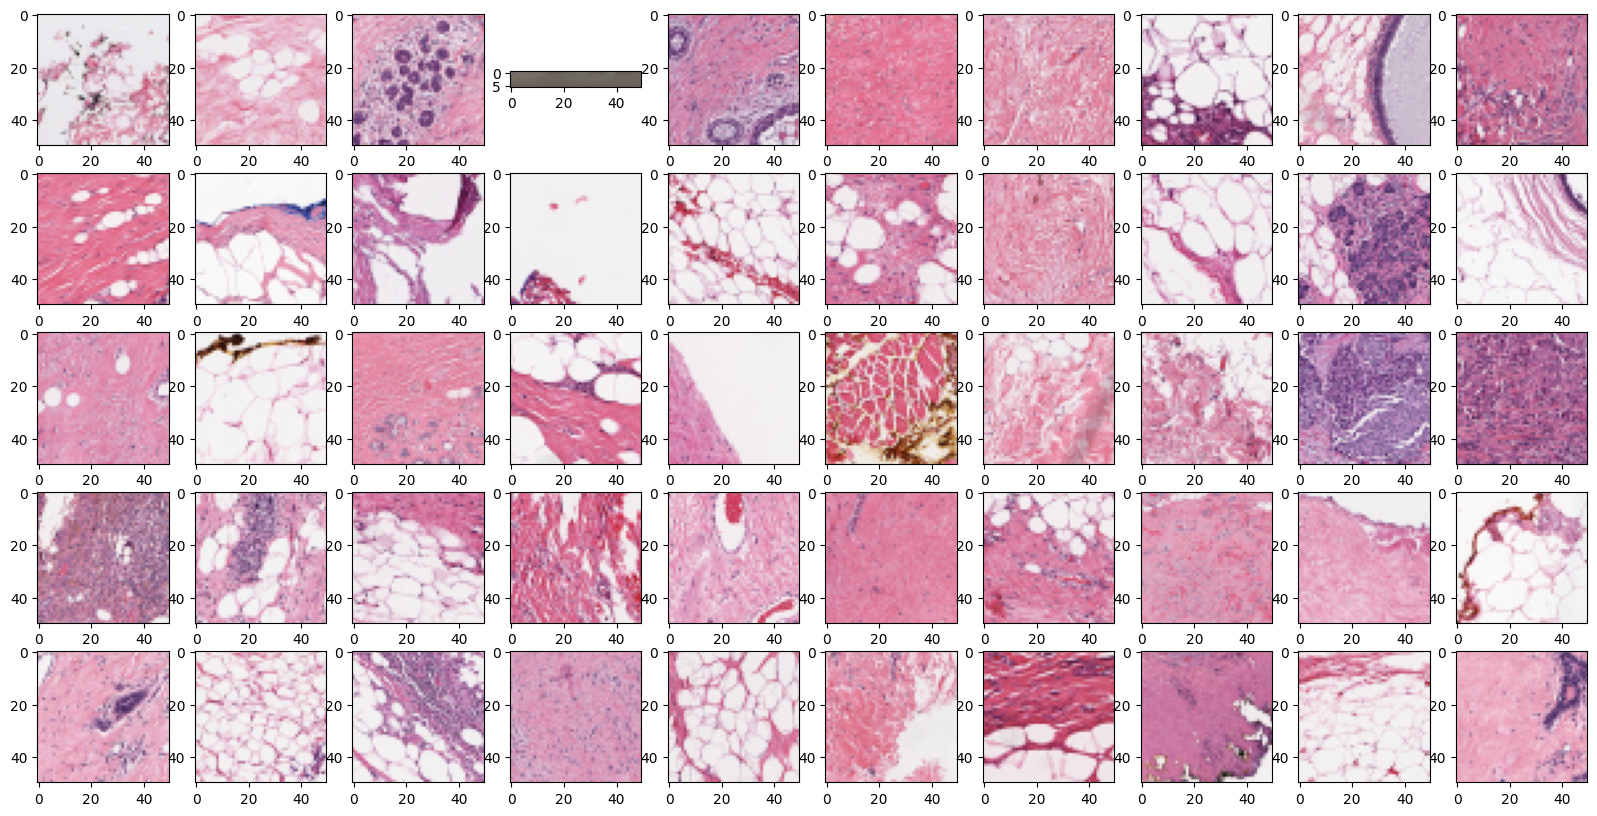

In [43]:
non_cancer_selection = np.random.choice(data[data.target == 0].index.values, size=50, replace=False)

fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for n in range(5):
    for m in range(10):
        idx = non_cancer_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Insights

* Cancer Tissur appears to be more viloet.

* But some non-caner tissue is also violet.


## Preparing the dataset

In [44]:
# Creating diresctory to store all images
all_images_dir = 'all_images_dir'

if os.path.isdir(all_images_dir):
    pass
else:
    os.mkdir(all_images_dir)
    


In [45]:
# This code copies all images from their seperate folders into the same 
# folder called all_images_dir.

'''
The directory structure is like:
    patient_id:
                0
                1
'''

patient_list = folder

for patient in patient_list:
    
    path_0 = "E:/FINAL_PROJECT/Breast_Cancer/Breast-cancer-detection-using-CNN/notebook/archive (13)/IDC_regular_ps50_idx5/" + str(patient) + '/0'
    path_1 = "E:/FINAL_PROJECT/Breast_Cancer/Breast-cancer-detection-using-CNN/notebook/archive (13)/IDC_regular_ps50_idx5/" + str(patient) + '/1'
    
    # create list of all files in folder 0
    file_list_0 = listdir(path_0)
    
    #create a list of all files in folder 1
    file_list_1 = listdir(path_1)
    
    # moving the 0 class images to all_images_dir
    for fname in file_list_0:
        
        src = os.path.join(path_0, fname)
        dst = os.path.join(all_images_dir, fname)
        shutil.copyfile(src, dst)
        
    # moving the 1 class images to all_images_dir
    for fname in file_list_1:
        
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_images_dir, fname)
        shutil.copyfile(src, dst)
        
    
        

In [46]:
# Total number of images
len(listdir(all_images_dir))

277524

### Creating dataframe of all images

In [47]:
image_list = os.listdir('all_images_dir')
df_data = pd.DataFrame(image_list, columns=['image_id'])

df_data.head()

image_id
0  10253_idx5_x1001_y1001_class0.png
1  10253_idx5_x1001_y1051_class0.png
2  10253_idx5_x1001_y1101_class0.png
3  10253_idx5_x1001_y1151_class0.png
4  10253_idx5_x1001_y1201_class0.png

In [48]:
# Defining helper functions

def extract_patient_id(x):
    
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id

def extract_target(x):
    
    a = x.split('_')
    b = a[4]
    target = b[5]
    
    return target

# creating new column named patient_id
df_data['patient_id'] = df_data['image_id'].apply(extract_patient_id)

#creating new column named target
df_data['target'] = df_data['image_id'].apply(extract_target)

df_data.head(10)

    

image_id patient_id target
0  10253_idx5_x1001_y1001_class0.png      10253      0
1  10253_idx5_x1001_y1051_class0.png      10253      0
2  10253_idx5_x1001_y1101_class0.png      10253      0
3  10253_idx5_x1001_y1151_class0.png      10253      0
4  10253_idx5_x1001_y1201_class0.png      10253      0
5  10253_idx5_x1001_y1251_class0.png      10253      0
6  10253_idx5_x1001_y1301_class0.png      10253      0
7  10253_idx5_x1001_y1351_class0.png      10253      0
8  10253_idx5_x1001_y1501_class0.png      10253      0
9  10253_idx5_x1001_y1551_class0.png      10253      0

In [49]:
# class distribution of the images

df_data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

### Balance the class distribution

* We can see that the class 1 images are higher in number that of class 0

* So to prevent this we balance the dataset

* We do this so that the Neural Network dose not lean on favouring only one class 

In [50]:
SAMPLE_SIZE = 78786

# take a sample of the majority class 0 (total = 198738)
df_0 = df_data[df_data['target'] == '0'].sample(SAMPLE_SIZE, random_state=101)
# take a sample of class 1 (total = 78786)
df_1 = df_data[df_data['target'] == '1'].sample(SAMPLE_SIZE, random_state=101)

# concat the two dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# Check the new class distribution
df_data['target'].value_counts()

target
0    78786
1    78786
Name: count, dtype: int64

### Creating train and test sets

In [51]:
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(141814, 3)
(15758, 3)


### Creating Directory Structure

In [52]:
# Creating new base directory
base_dir ='base_dir'
os.mkdir(base_dir)

# Creating train directory inside base directory
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# Creating validation directory inside base directory
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# create new folders inside train_dir
a_no_idc = os.path.join(train_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(train_dir, 'b_has_idc')
os.mkdir(b_has_idc)


# create new folders inside val_dir
a_no_idc = os.path.join(val_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(val_dir, 'b_has_idc')
os.mkdir(b_has_idc)




FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'base_dir'

In [53]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['a_no_idc', 'b_has_idc']

In [54]:
# Set the id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [55]:
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Transfering the train images
for image in train_list:

    try: 
        fname = image
        target = df_data.loc[image, 'target']

        if target == '0':
            label = 'a_no_idc'
        if target == '1':
            label = 'b_has_idc'

        # source path to image
        src = os.path.join(all_images_dir, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # move the image from the source to the destination
        shutil.move(src, dst)
    except: 
        continue

for image in val_list:

    try: 
        fname = image
        target = df_data.loc[image,'target']

        if target == '0':
            label = 'a_no_idc'
        if target == '1':
            label = 'b_has_idc'


        # source path to image
        src = os.path.join(all_images_dir, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # move the image from the source to the destination
        shutil.move(src, dst)

    except:
        continue

        

In [56]:
# check how many val images we have in each folder
print(len(os.listdir('base_dir/train_dir/a_no_idc')))
print(len(os.listdir('base_dir/train_dir/b_has_idc')))

70907
70907


### Setting up image generators

In [57]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [58]:
IMAGE_SIZE = 50

In [61]:

datagen = ImageDataGenerator(rescale = 1.0 / 255,
                             rotation_range = 90,
                             zoom_range = 0.2,
                             horizontal_flip=True,
                             vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 141814 images belonging to 2 classes.
Found 15758 images belonging to 2 classes.
Found 15758 images belonging to 2 classes.


In [62]:
# Building the model
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

c:\Users\DAI.STUDENTSDC\PycharmProjects\pythonProject5\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 18, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,306 (1.96 MB)

 Trainable params: 514,306 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [63]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [64]:
filepath = "model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, steps_per_epoch=int(train_steps), 
                    validation_data=val_gen,
                    validation_steps=int(val_steps),
                    epochs=50, verbose=1,
                   callbacks=callbacks_list)

try:
    model.save('/kaggle/working/model.h5')
except:
    pass

try:
    model.save('E:/FINAL_PROJECT/Breast_Cancer/Breast-cancer-detection-using-CNN/notebook/breast-cancer-detection-using-cnn.ipynb/model.keras')
except:
    pass

c:\Users\DAI.STUDENTSDC\PycharmProjects\pythonProject5\.conda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
14182/14182 ━━━━━━━━━━━━━━━━━━━━ 5267s 371ms/step - accuracy: 0.7183 - loss: 0.5378 - val_accuracy: 0.8325 - val_loss: 0.3998 - learning_rate: 1.0000e-04
Epoch 2/50


c:\Users\DAI.STUDENTSDC\PycharmProjects\pythonProject5\.conda\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
c:\Users\DAI.STUDENTSDC\PycharmProjects\pythonProject5\.conda\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
c:\Users\DAI.STUDENTSDC\PycharmProjects\pythonProject5\.conda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14182/14182 ━━━━━━━━━━━━━━━━━━━━ 0s 13us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50


c:\Users\DAI.STUDENTSDC\PycharmProjects\pythonProject5\.conda\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


14182/14182 ━━━━━━━━━━━━━━━━━━━━ 1916s 135ms/step - accuracy: 0.8198 - loss: 0.4148 - val_accuracy: 0.8483 - val_loss: 0.3609 - learning_rate: 1.0000e-04
Epoch 4/50
14182/14182 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/50
14182/14182 ━━━━━━━━━━━━━━━━━━━━ 613s 43ms/step - accuracy: 0.8375 - loss: 0.3848 - val_accuracy: 0.8492 - val_loss: 0.3631 - learning_rate: 1.0000e-04
Epoch 6/50
14182/14182 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/50
14182/14182 ━━━━━━━━━━━━━━━━━━━━ 532s 38ms/step - accuracy: 0.8448 - loss: 0.3712 - val_accuracy: 0.8565 - val_loss: 0.3470 - learning_rate: 1.0000e-04
Epoch 8/50
14182/14182 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/50
14182/14182 ━━━━━━━━━━━━━━━━━━━━ 540s 38ms/step - accuracy: 0.8479 - loss: 0.3627 - val_accuracy: 0.8606 - val_loss: 0.3440 - learn

In [68]:
model.save('E:/FINAL_PROJECT/Breast_Cancer/Breast-cancer-detection-using-CNN/notebook/model.h5')


In [66]:
model.save('E:/FINAL_PROJECT/Breast_Cancer/Breast-cancer-detection-using-CNN/notebook/model.keras')


In [69]:
import os
os.makedirs('E:/FINAL_PROJECT/Breast_Cancer/Breast-cancer-detection-using-CNN/notebook/', exist_ok=True)


### Evaluating the model

In [70]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'compile_metrics']

In [72]:
# Here the best epoch will be used.

model.load_weights('model.keras')

val_loss, val_acc = model.evaluate(
    test_gen,
    steps=len(df_val)
)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

15758/15758 ━━━━━━━━━━━━━━━━━━━━ 111s 7ms/step - accuracy: 0.8603 - loss: 0.3080
val_loss: 0.3023975193500519
val_acc: 0.8783475160598755


In [73]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = model.evaluate(
    test_gen,
    steps=len(df_val)
)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

15758/15758 ━━━━━━━━━━━━━━━━━━━━ 115s 7ms/step - accuracy: 0.8570 - loss: 0.3088
val_loss: 0.3016205132007599
val_acc: 0.8793628811836243


### Plotting the training curves

<Figure size 640x480 with 0 Axes>

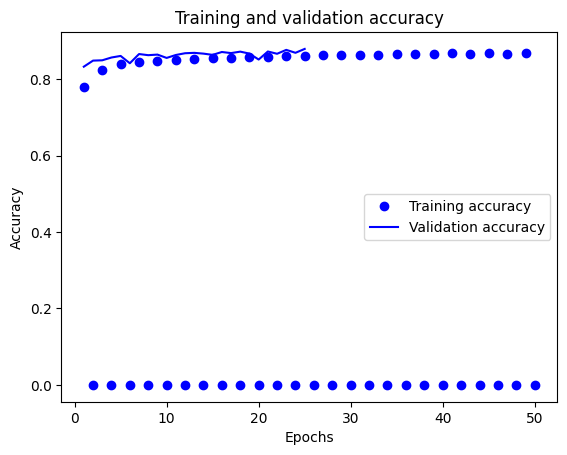

<Figure size 640x480 with 0 Axes>

In [78]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
epochs_acc = range(1, len(acc) + 1)
epochs_val_acc = range(1, len(val_acc) + 1)


plt.plot(epochs_acc, acc, 'bo', label='Training accuracy')  # 'bo' indicates blue circles
plt.plot(epochs_val_acc, val_acc, 'b', label='Validation accuracy')  # 'b' indicates a blue line
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the figure
plt.figure()

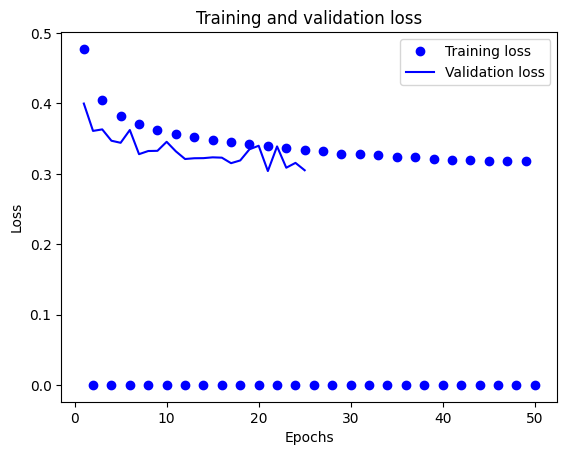

In [75]:
# Get the lengths of training and validation loss
epochs_loss = range(1, len(loss) + 1)
epochs_val_loss = range(1, len(val_loss) + 1)

# Plot training and validation loss
plt.plot(epochs_loss, loss, 'bo', label='Training loss')  # 'bo' indicates blue circles
plt.plot(epochs_val_loss, val_loss, 'b', label='Validation loss')  # 'b' indicates a blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


### Make a prediction on the val set
We need these predictions to calculate the AUC score, print the Confusion Matrix and calculate the F1 score.

In [80]:
# make a prediction
predictions = model.predict(test_gen, steps=len(df_val), verbose=1)

15758/15758 ━━━━━━━━━━━━━━━━━━━━ 123s 8ms/step


In [81]:
predictions.shape

(15758, 2)

In [82]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

In [83]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_idc', 'has_idc'])

df_preds.head()

no_idc   has_idc
0  0.229734  0.770266
1  0.188289  0.811711
2  0.841858  0.158142
3  0.991078  0.008922
4  0.384655  0.615345

In [ ]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_idc']

### Calculating the AUC Score

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9459758550448937

### Creating the confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
        

In [ ]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [ ]:
test_labels.shape

(15758,)

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
# Print the label associated with each class
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

Confusion matrix, without normalization
[[6746 1133]
 [ 843 7036]]


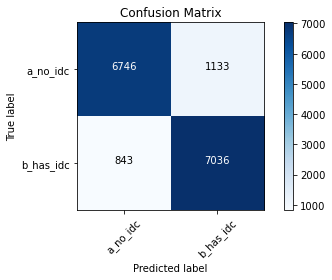

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['a_no_idc', 'b_has_idc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Creating a classfifcation Report

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

    a_no_idc       0.89      0.86      0.87      7879
   b_has_idc       0.86      0.89      0.88      7879

    accuracy                           0.87     15758
   macro avg       0.88      0.87      0.87     15758
weighted avg       0.88      0.87      0.87     15758



**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

### Conclusion

* From the above report we can see that the model gives us admirable results.

* The model can be improved.

* The recall for each class should be ideally be above 0.90

* The present recall which the model produces is good enough.

* For use in the real world the recall can be further improved.

* This model can help pathologists detect cancer on tissue faster

* The manual examining of tissue slides would not be required